In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import pycaret.classification as clf
import pycaret.regression as reg

import warnings
warnings.filterwarnings("ignore")
from xgboost import XGBClassifier, XGBRegressor 
from sklearn.model_selection import GridSearchCV


In [2]:
df_raw = pd.read_csv(r"C:\Users\arham\Desktop\cdnow.csv")
df_raw

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69659 entries, 0 to 69658
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   69659 non-null  int64  
 1   customer_id  69659 non-null  int64  
 2   date         69659 non-null  object 
 3   quantity     69659 non-null  int64  
 4   price        69659 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.7+ MB


In [4]:
df = df_raw.copy()

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])
df.dropna(inplace=True)


# Verify the data types
print(df.dtypes)
df

Unnamed: 0              int64
customer_id             int64
date           datetime64[ns]
quantity                int64
price                 float64
dtype: object


,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [5]:
cdnow_first_purchase_tbl = df.sort_values(by=['customer_id', 'date']).groupby('customer_id').first()
cdnow_first_purchase_tbl

,Unnamed: 0,date,quantity,price
customer_id,,,,
1,0,1997-01-01,1,11.77
2,1,1997-01-12,1,12.00
3,3,1997-01-02,2,20.76
4,9,1997-01-01,2,29.33
5,13,1997-01-01,2,29.33
...,...,...,...,...
23566,69651,1997-03-25,2,36.00
23567,69652,1997-03-25,1,20.97
23568,69653,1997-03-25,1,22.97


In [6]:
# Cohort Analysis

In [7]:
cdnow_first_purchase_tbl['date'].min()


Timestamp('1997-01-01 00:00:00')

In [8]:
cdnow_first_purchase_tbl['date'].max()


Timestamp('1997-03-25 00:00:00')

<Axes: xlabel='date'>

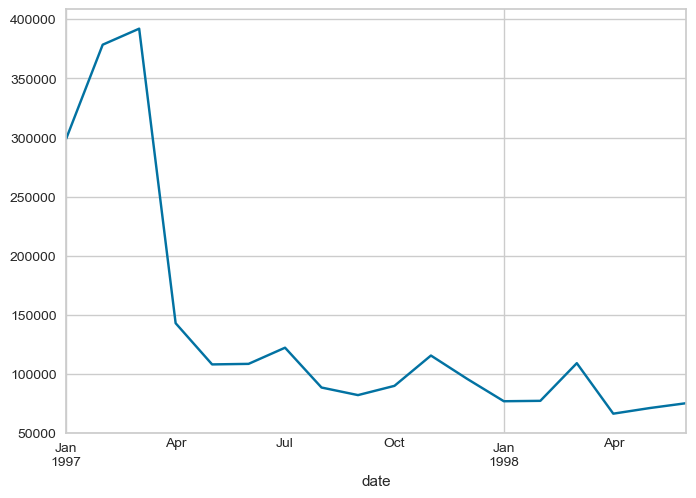

In [9]:
df.reset_index().set_index('date')['price'].resample(rule='MS').sum().plot()

In [10]:
ids = df['customer_id'].unique()
ids_selected = ids[0:10]
ids_selected

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10], dtype=int64)

In [11]:
cdnow_cust_id_subset_df = df[df['customer_id'].isin(ids_selected)].groupby(['customer_id', 'date']).sum().reset_index()
cdnow_cust_id_subset_df

,customer_id,date,Unnamed: 0,quantity,price
0,1,1997-01-01,0,1,11.77
1,2,1997-01-12,3,6,89.00
2,3,1997-01-02,3,2,20.76
3,3,1997-03-30,4,2,20.76
4,3,1997-04-02,5,2,19.54
5,3,1997-11-15,6,5,57.45
6,3,1997-11-25,7,4,20.96
7,3,1998-05-28,8,1,16.99
8,4,1997-01-01,9,2,29.33
9,4,1997-01-18,10,2,29.73


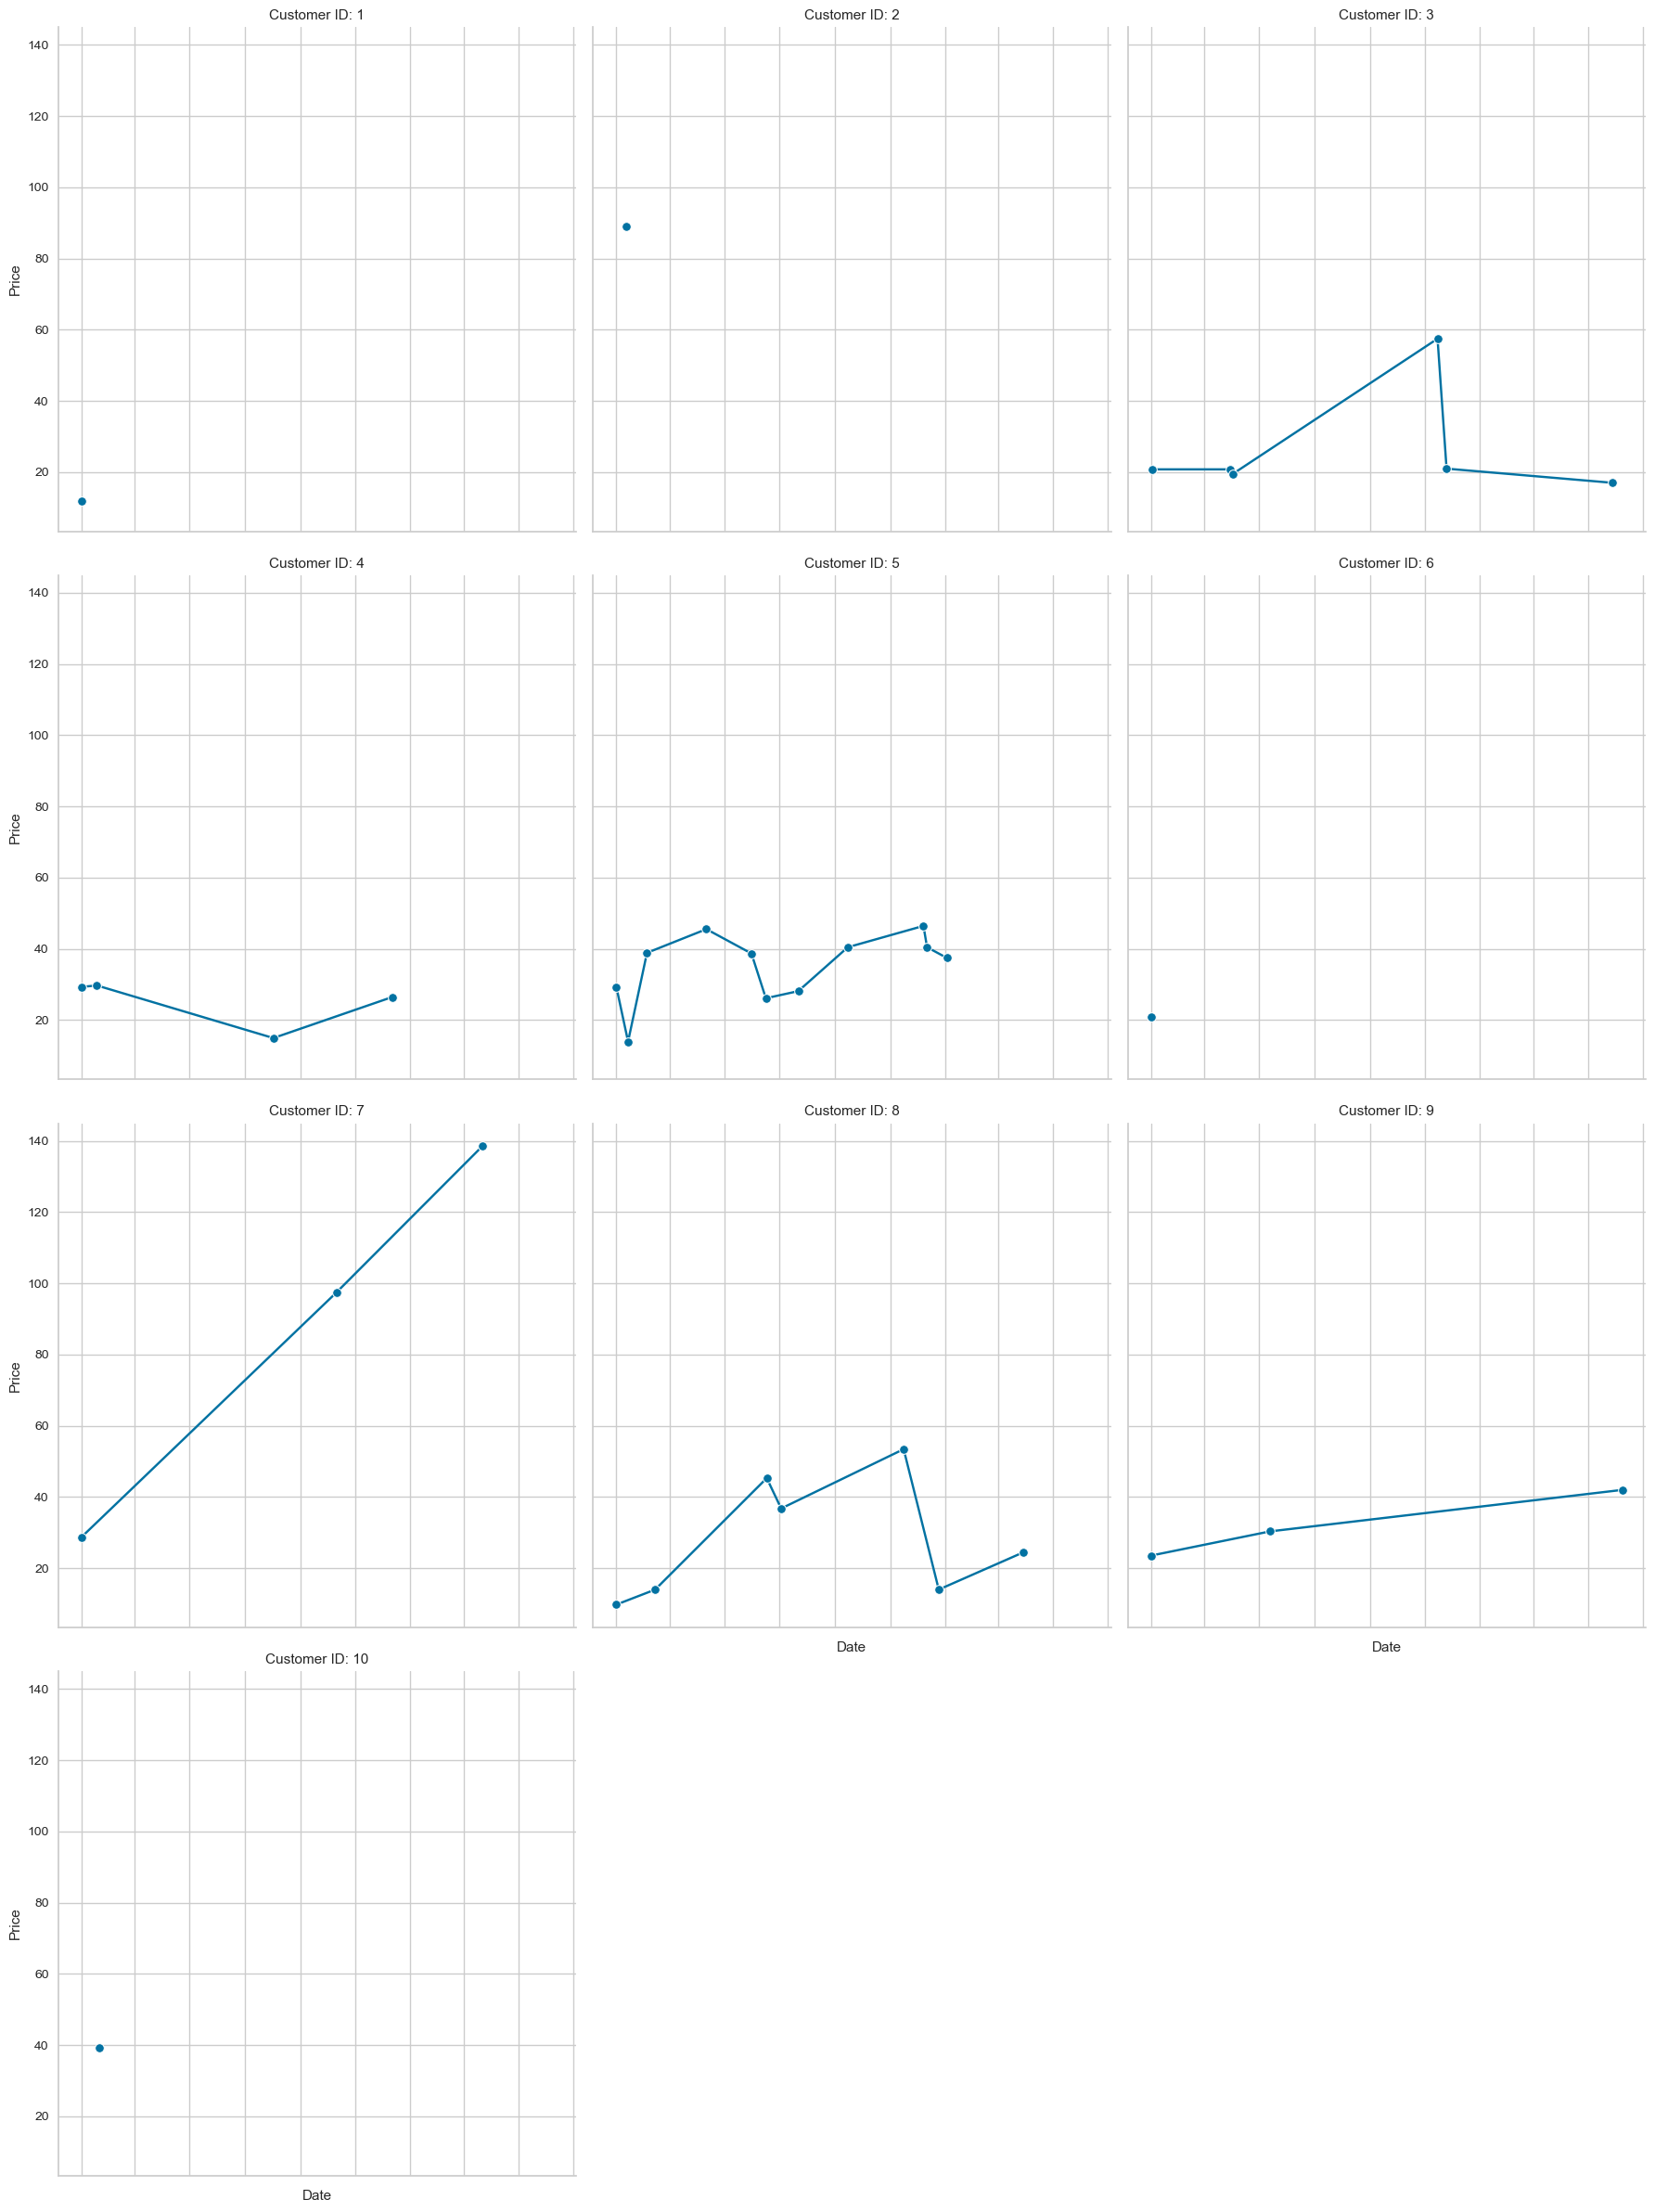

In [12]:
# Create a FacetGrid with one subplot for each customer_id
g = sns.FacetGrid(cdnow_cust_id_subset_df, col="customer_id", col_wrap=3, height=6)

# Map the data to the FacetGrid
g = g.map(sns.lineplot, "date", "price", marker="o")

# Customize the plots
g.set_axis_labels("Date", "Price")
g.set_titles("Customer ID: {col_name}")
g.set_xticklabels(rotation=45)

# Adjust layout to avoid overlapping
plt.tight_layout()

# Show the plots
plt.show()


Customers 1,2,6, and 10 are customers that show one purchase buys behaviour
Customer 3 seems like a frequent buyer. 
Customers 4 and 5 have a frequent buying pattern but then stops arruptly. 

In [13]:
#Temporal splitting 
n_days = 90 
max_date = df['date'].max()
#cutoff is the 90 days before the end of the dataset
cutoff = max_date - pd.to_timedelta(n_days, unit = "d")
cutoff

Timestamp('1998-04-01 00:00:00')

In [14]:
temporal_in_df = df[df['date'] <= cutoff]
temporal_in_df

,Unnamed: 0,customer_id,date,quantity,price
0,0,1,1997-01-01,1,11.77
1,1,2,1997-01-12,1,12.00
2,2,2,1997-01-12,5,77.00
3,3,3,1997-01-02,2,20.76
4,4,3,1997-03-30,2,20.76
...,...,...,...,...,...
69654,69654,23568,1997-04-05,4,83.74
69655,69655,23568,1997-04-22,1,14.99
69656,69656,23569,1997-03-25,2,25.74
69657,69657,23570,1997-03-25,3,51.12


In [15]:
temporal_out_df = df[df['date'] > cutoff]
temporal_out_df

,Unnamed: 0,customer_id,date,quantity,price
8,8,3,1998-05-28,1,16.99
38,38,9,1998-06-08,2,41.98
68,68,25,1998-04-17,1,12.99
69,69,25,1998-05-25,1,10.49
70,70,25,1998-06-03,3,24.97
...,...,...,...,...,...
69583,69583,23534,1998-05-02,1,10.48
69623,69623,23555,1998-05-01,4,49.96
69624,69624,23555,1998-06-10,2,27.48
69631,69631,23556,1998-06-07,2,28.98


In [16]:
targets_df = temporal_out_df.drop(['quantity', 'Unnamed: 0'], axis=1).groupby('customer_id').sum(numeric_only=True).rename({'price': 'spend_90_total'}, axis = 1).assign(spend_90_flag=1)
targets_df

,spend_90_total,spend_90_flag
customer_id,,
3,16.99,1
9,41.98,1
25,73.43,1
29,48.45,1
31,117.99,1
...,...,...
23529,40.56,1
23534,10.48,1
23555,77.44,1


In [17]:
max_date = temporal_in_df['date'].max()

recency_features_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').apply(lambda x: (x['date'].max() - max_date) / pd.to_timedelta(1,"day")).to_frame().set_axis(["recency"], axis = 1)
recency_features_df

,recency
customer_id,
1,-455.0
2,-444.0
3,-127.0
4,-110.0
5,-88.0
...,...
23566,-372.0
23567,-372.0
23568,-344.0


In [18]:
frequency_features_df = temporal_in_df[['customer_id', 'date']].groupby('customer_id').count().set_axis(['frequency'], axis = 1)
frequency_features_df

,frequency
customer_id,
1,1
2,2
3,5
4,4
5,11
...,...
23566,1
23567,1
23568,3


In [19]:
price_features_df = temporal_in_df.groupby('customer_id').aggregate({'price': ("sum", "mean")}).set_axis(['price_sum', 'price_mean'], axis = 1)
price_features_df

,price_sum,price_mean
customer_id,,
1,11.77,11.770000
2,89.00,44.500000
3,139.47,27.894000
4,100.50,25.125000
5,385.61,35.055455
...,...,...
23566,36.00,36.000000
23567,20.97,20.970000
23568,121.70,40.566667


In [20]:
features_df = pd.concat([recency_features_df, frequency_features_df, price_features_df], axis =1).merge(targets_df, left_index = True, right_index = True, how = "left").fillna(0)

In [21]:
features_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag
customer_id,,,,,,
1,-455.0,1,11.77,11.770000,0.00,0.0
2,-444.0,2,89.00,44.500000,0.00,0.0
3,-127.0,5,139.47,27.894000,16.99,1.0
4,-110.0,4,100.50,25.125000,0.00,0.0
5,-88.0,11,385.61,35.055455,0.00,0.0
...,...,...,...,...,...,...
23566,-372.0,1,36.00,36.000000,0.00,0.0
23567,-372.0,1,20.97,20.970000,0.00,0.0
23568,-344.0,3,121.70,40.566667,0.00,0.0


In [22]:
reg_setup = reg.setup(
    data = features_df.drop('spend_90_flag', axis = 1),
    target = 'spend_90_total', 
    train_size = 0.8, 
    normalize = True,
    session_id = 123, 
    verbose = True, 
    log_experiment = False
)

,Description,Value
0,Session id,123
1,Target,spend_90_total
2,Target type,Regression
3,Original data shape,"(23570, 5)"
4,Transformed data shape,"(23570, 5)"
5,Transformed train set shape,"(18856, 5)"
6,Transformed test set shape,"(4714, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [23]:
xgb_reg_model = reg.create_model('xgboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,12.2735,1551.1425,39.3845,0.2666,1.5517,0.8340
1,10.7102,982.2900,31.3415,0.4044,1.5101,0.8055
2,10.6309,951.5394,30.8470,0.5952,1.5422,0.7947
3,10.6535,949.6237,30.8160,0.0184,1.5344,0.7623
4,11.1989,1310.6755,36.2033,0.0858,1.5413,1.0346
5,10.8654,1084.0479,32.9249,0.1140,1.5490,0.9055
6,11.1273,1319.3774,36.3232,0.3041,1.5216,0.7865
7,10.7967,1056.4443,32.5030,0.2013,1.5153,0.7943
8,11.2747,1796.5095,42.3853,0.6172,1.4980,0.8259


In [24]:
reg_predictions_df = reg.predict_model(xgb_reg_model, data = features_df).sort_values('prediction_label', ascending = False)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extreme Gradient Boosting,7.8298,484.8910,22.0202,0.7456,1.4072,0.6053


In [25]:
reg_predictions_df

,recency,frequency,price_sum,price_mean,spend_90_flag,spend_90_total,prediction_label
customer_id,,,,,,,
7592,-2.0,165,11478.019531,69.563759,1.0,2512.909912,2513.454346
14048,0.0,180,7267.149902,40.373055,1.0,1709.180054,1705.019043
22061,-2.0,118,3371.800049,28.574575,1.0,577.099976,1414.214355
7983,-9.0,105,5824.140137,55.467999,1.0,1148.930054,1161.221802
6569,-8.0,36,3912.300049,108.675003,1.0,1055.699951,1053.003540
...,...,...,...,...,...,...,...
23379,-281.0,6,907.969971,151.328339,0.0,0.000000,-16.151703
15457,-2.0,5,363.570007,72.713997,0.0,0.000000,-19.582949
8450,-17.0,4,368.809998,92.202499,0.0,0.000000,-24.542559


In [26]:
 clf_setup = clf.setup(
     data = features_df.drop('spend_90_total', axis =1),
     target = 'spend_90_flag', 
     train_size = 0.8, 
     session_id = 123, 
     verbose = True,
     log_experiment = False
 )

,Description,Value
0,Session id,123
1,Target,spend_90_flag
2,Target type,Binary
3,Original data shape,"(23570, 5)"
4,Transformed data shape,"(23570, 5)"
5,Transformed train set shape,"(18856, 5)"
6,Transformed test set shape,"(4714, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [27]:
xgb_clf_model = clf.create_model('xgboost')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8648,0.8314,0.2906,0.5347,0.3765,0.3081,0.3261
1,0.8807,0.8249,0.3106,0.6560,0.4216,0.3644,0.3962
2,0.8727,0.7809,0.2803,0.5968,0.3814,0.3207,0.3493
3,0.8839,0.8306,0.3750,0.6471,0.4748,0.4147,0.4342
4,0.8696,0.8240,0.3106,0.5616,0.4000,0.3336,0.3520
5,0.8712,0.7871,0.3295,0.5686,0.4173,0.3506,0.3671
6,0.8695,0.8245,0.2841,0.5682,0.3788,0.3148,0.3385
7,0.8780,0.8314,0.3485,0.6133,0.4444,0.3817,0.4010
8,0.8716,0.8385,0.2992,0.5809,0.3950,0.3313,0.3542


In [28]:
clf_predictions_df = clf.predict_model(xgb_clf_model, data = features_df, raw_score = True).sort_values('prediction_score_1', ascending = False)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extreme Gradient Boosting,0.9030,0.9013,0.4081,0.8018,0.5409,0.4930,0.5282


In [29]:
clf_predictions_df

,recency,frequency,price_sum,price_mean,spend_90_total,spend_90_flag,prediction_label,prediction_score_0,prediction_score_1
customer_id,,,,,,,,,
19597,-1.0,97,2023.000000,20.855671,334.570007,1.0,1,0.0003,0.9997
2484,0.0,59,1438.930054,24.388643,345.429993,1.0,1,0.0005,0.9995
10079,0.0,62,2100.379883,33.877098,100.430000,1.0,1,0.0006,0.9994
710,-2.0,51,2216.449951,43.459805,285.850006,1.0,1,0.0007,0.9993
1722,-4.0,43,984.909973,22.904884,197.360001,1.0,1,0.0011,0.9989
...,...,...,...,...,...,...,...,...,...
1643,-449.0,2,89.980003,44.990002,0.000000,0.0,0,0.9995,0.0005
1325,-450.0,1,87.400002,87.400002,0.000000,0.0,0,0.9995,0.0005
1394,-450.0,1,209.960007,209.960007,0.000000,0.0,0,0.9997,0.0003


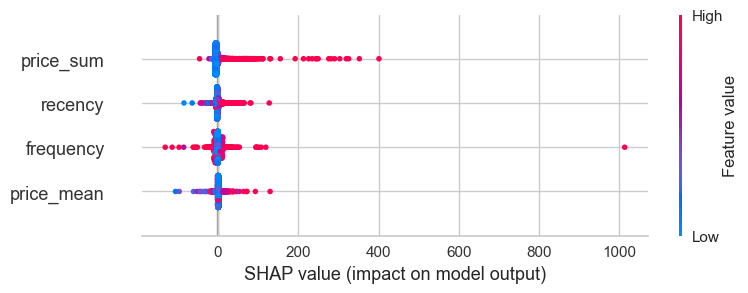

In [30]:
reg.interpret_model(xgb_reg_model)

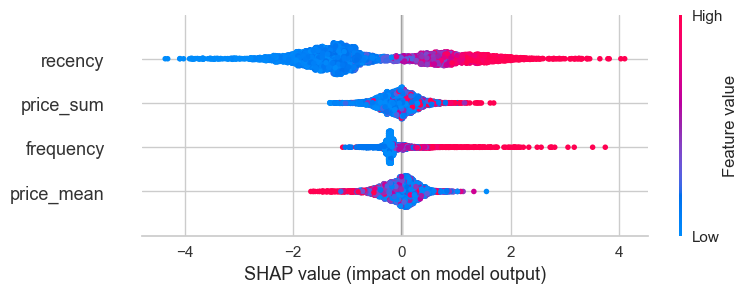

In [31]:
clf.interpret_model(xgb_clf_model)

# Key business insights
1. Increasing CLV 90-day Sales value - if we want to increse sales value, we should focus on the customers with the highest historical sales values and get them to spend more

2. Increasing CLV 90-day Sales probability - If we want to increase this, recency is the most important to increasing probability of a customer making a purchase in the next 90 days


In [32]:
# what would happend if you could increase revenue by 10%
reg_predictions_df['prediction_label'].sum()

211518.9

In [33]:
211518.9*0.1*4


84607.56

In [34]:
# company would produce almost 85k

In [37]:
top_20_customers = reg_predictions_df.head(20).index.to_list()
top_20_customers

[7592,
 14048,
 22061,
 7983,
 6569,
 7931,
 499,
 16517,
 5223,
 20316,
 4995,
 21950,
 22492,
 8250,
 12352,
 3901,
 10197,
 12367,
 2908,
 21739]